In [1]:
%load_ext autoreload
%autoreload 2
from animalclef.spark import get_spark
from pyspark.sql import functions as F

spark = get_spark(cores=4, memory="2g")
display(spark)

25/05/09 05:47:07 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/09 05:47:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 05:47:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/09 05:47:08 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/05/09 05:47:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Note that unlike other notebooks, this is being run not on PACE but rather on a personal machine. This is because PACE has been down for a while.

In [2]:
from pathlib import Path

root = Path.home() / "scratch/animalclef"
metadata = spark.read.csv(f"{root}/raw/metadata.csv", header=True, inferSchema=True)
metadata.printSchema()
display(metadata.count())

root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- path: string (nullable = true)
 |-- date: date (nullable = true)
 |-- orientation: string (nullable = true)
 |-- species: string (nullable = true)
 |-- split: string (nullable = true)
 |-- dataset: string (nullable = true)



15209

In [3]:
embeddings = spark.read.parquet(f"{root}/processed/embeddings.parquet")
embeddings = embeddings.select(
    "image_id",
    F.array(
        *[F.col(c).cast("float") for c in embeddings.columns if c.startswith("embed_")]
    ).alias("embeddings"),
)
embeddings.printSchema()
embeddings.show(n=3, truncate=100, vertical=True)
display(embeddings.count())

root
 |-- image_id: long (nullable = true)
 |-- embeddings: array (nullable = false)
 |    |-- element: float (containsNull = true)



25/05/09 05:47:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0----------------------------------------------------------------------------------------------------------
 image_id   | 0                                                                                                    
 embeddings | [1.1954931, -1.3708293, 5.5501676, 1.0094011, -6.0560822, 3.8844035, -0.48466238, -0.82771224, -0... 
-RECORD 1----------------------------------------------------------------------------------------------------------
 image_id   | 1                                                                                                    
 embeddings | [-0.39057606, -2.747425, 3.3069062, -1.7544745, -3.3268454, 1.0593071, 0.3443672, -1.1765201, -0.... 
-RECORD 2----------------------------------------------------------------------------------------------------------
 image_id   | 2                                                                                                    
 embeddings | [1.0195563, -2.4293716, 0.21673673, 0.42816764, -0.8387890

15209

In [4]:
antijoin = metadata.join(embeddings.select("image_id"), on="image_id", how="left_anti")
display(antijoin.count())

0

In [5]:
df = metadata.join(embeddings, on="image_id", how="inner")
pdf = df.select("image_id", "identity", "dataset", "embeddings").toPandas()
pdf

,image_id,identity,dataset,embeddings
0,0,LynxID2025_lynx_37,LynxID2025,"[1.1954931020736694, -1.3708293437957764, 5.55..."
1,1,LynxID2025_lynx_37,LynxID2025,"[-0.3905760645866394, -2.747425079345703, 3.30..."
2,2,LynxID2025_lynx_49,LynxID2025,"[1.0195562839508057, -2.4293715953826904, 0.21..."
3,3,None,LynxID2025,"[1.9632158279418945, 0.32992684841156006, 0.65..."
4,4,LynxID2025_lynx_13,LynxID2025,"[2.363952159881592, -5.049680709838867, 2.8787..."
...,...,...,...,...
15204,15204,None,SeaTurtleID2022,"[-0.6587691307067871, 0.5694342255592346, -6.1..."
15205,15205,None,SeaTurtleID2022,"[-0.5976455211639404, 0.18739935755729675, -7...."
15206,15206,None,SeaTurtleID2022,"[1.570137858390808, 2.9094202518463135, -3.371..."
15207,15207,None,SeaTurtleID2022,"[-3.564107656478882, 0.7208312153816223, -6.34..."


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pacmap import PaCMAP


X_cls = np.stack(pdf.embeddings.values)
display(X_cls.shape)

g_pm_cls = PaCMAP().fit_transform(X_cls)

(15209, 128)

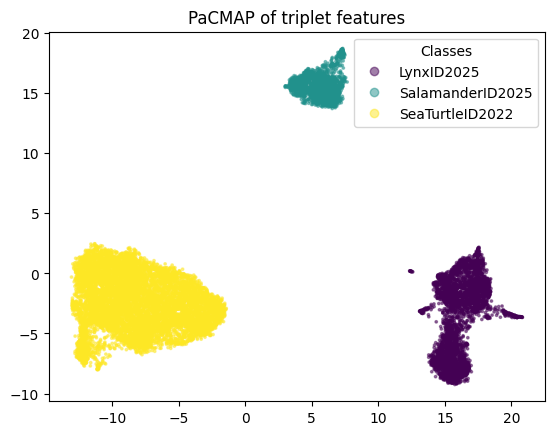

In [7]:
# map label to colors
from sklearn import preprocessing


def plot_emb(X, labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    fig = plt.scatter(
        X[:, 0],
        X[:, 1],
        c=le.transform(labels),
        rasterized=True,
        s=3,
        alpha=0.5,
    )
    plt.legend(
        handles=fig.legend_elements()[0],
        labels=list(le.classes_),
        title="Classes",
    )


plt.title("PaCMAP of triplet features")
plot_emb(g_pm_cls, pdf.dataset)
plt.show()

How do we plot individuals? Well, one idea is to learn a 1d embedding that we can use to show that individuals form a gradient within a cluster. If there are a bunch of spots, then that means that it could be sorted better. We can transform this embedding from a float into an ordering.

In [8]:
@F.udf("array<float>")
def mean_embedding(embeddings):
    return np.mean(np.stack(embeddings), axis=0).tolist()


ids = (
    df.groupBy("identity")
    .agg(F.collect_list("embeddings").alias("embeddings"))
    .select(
        "identity",
        mean_embedding("embeddings").alias("embeddings"),
    )
    .toPandas()
)
display(ids.head())

25/05/09 05:47:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,identity,embeddings
0,LynxID2025_lynx_04,"[1.4878411293029785, -0.7625392079353333, 3.71..."
1,LynxID2025_lynx_08,"[0.8570535182952881, -4.668135166168213, 2.438..."
2,LynxID2025_lynx_16,"[1.148680329322815, -5.213956832885742, 1.7856..."
3,LynxID2025_lynx_17,"[1.071122169494629, -2.2495901584625244, 2.029..."
4,LynxID2025_lynx_38,"[0.730568528175354, -1.6233373880386353, 1.194..."


In [9]:
# now learn identity embedding on centroids
from umap import UMAP

X_id = np.stack(ids.embedding.values)
g_id_pm = PaCMAP(n_components=1).fit_transform(X_id)
g_id = UMAP(n_components=1).fit_transform(X_id)

# add the column to the original df and then compute runlengths based on orderings
ids["umap_emb"] = g_id
ids["pmap_emb"] = g_id_pm
ids.head()

/home/anthony/clef/animalclef-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'DataFrame' object has no attribute 'embedding'

In [ ]:
# and now let's plot 2d pacman
g_id_pm2d = PaCMAP(n_components=2).fit_transform(X_id)

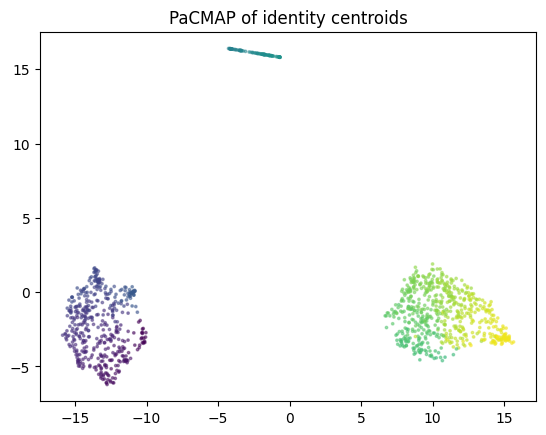

In [ ]:
def plot_emb_float(X, c):
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=c,
        rasterized=True,
        s=3,
        alpha=0.5,
        # viridis?
        cmap="viridis",
    )


plt.title("PaCMAP of identity centroids")
plot_emb_float(g_id_pm2d, ids["pmap_emb"])
plt.show()

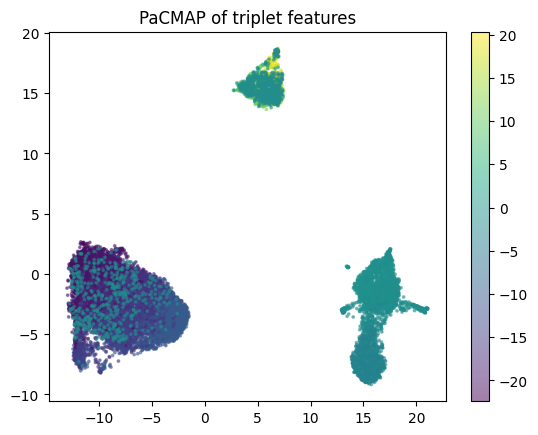

In [ ]:
# and then one last plot, we get the original dataset and plot the color based on the identity
merged = pdf.merge(
    ids[["identity", "umap_emb", "pmap_emb"]],
    on="identity",
    how="left",
)
plt.title("PaCMAP of triplet features")
y = merged["pmap_emb"].values
# y = (y - y.min()) / (y.max() - y.min())
plot_emb_float(g_pm_cls, y)
plt.colorbar()
plt.show()

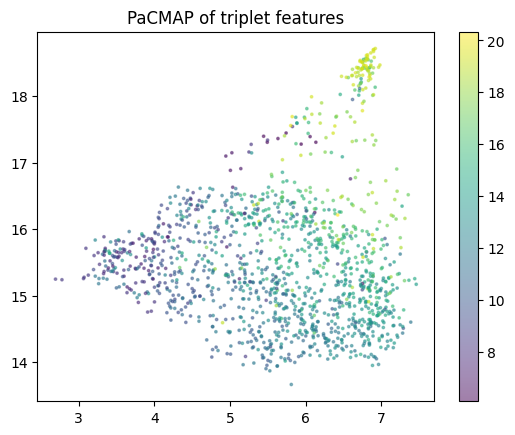

In [ ]:
# now only look at the scatter of the salamanders

# get index of salamander index
where = (merged.dataset == "SalamanderID2025") & (~merged.identity.isnull())
# now get the subset of the data
plt.title("PaCMAP of triplet features")
y = merged[where]["pmap_emb"].values
plot_emb_float(g_pm_cls[where], y)
plt.colorbar()
plt.show()